# Data improvement

## Train a neural network with classical binary cross entropy loss

We have obtained a set of data points that are close to the actual basin boundary(error margin $\delta$ = 0.01). We use this dataset to train a neural network for classification.

In [125]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [126]:
import numpy as np
import math
from scipy.integrate import solve_ivp

In [127]:
# Lorenz parameters.
sigma, beta, r = 10, 8/3, 10

In [128]:
def lorenz(t, X, sigma, beta, r):
    """The Lorenz equations."""
    x, y, z = X
    xp = sigma*(y - x)
    yp = r*x - y - x*z
    zp = -beta*z + x*y
    return xp, yp, zp

In [129]:
# Check if the trajectory is attracted to the concerned Lorenz attractor
def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))
lorenz_attractor = (math.sqrt(24), math.sqrt(24), 9)

def is_attracted(x, y, z):
    return euclidean_distance((x, y, z), lorenz_attractor) < 0.01

## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0 ,z0):
    tmax, n = 1500, 100000
    soln = solve_ivp(lorenz, (0, tmax), (x0, y0, z0), args=(sigma, beta, r),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y, z = soln.sol(t)
    return is_attracted(x[n-1], y[n-1], z[n-1])

In [130]:
## Load the dataset
class LorenzDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor([self.data.iloc[idx].x0, self.data.iloc[idx].y0, self.data.iloc[idx].z0]).float()
        label = torch.tensor(self.data.iloc[idx].attracted).float()
        return features, label
    
dataset = LorenzDataset('dataset_near.csv')

dataset_train, dataset_test = torch.utils.data.random_split(dataset, [16000, 4000])

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [131]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3,128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
net = Net()

In [132]:
## Set up loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [133]:
# Check if MPS is available and set the device accordingly
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [134]:
# Move the model to the device
net = net.to(device)
criterion.to(device)

## Train the network
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    mini_batch_count = 0
    for features, labels in dataset_train:
        # Ensure features is a Tensor
        if not isinstance(features, torch.Tensor):
            features = torch.Tensor(features)

        # Ensure labels is a Tensor
        if not isinstance(labels, torch.Tensor):
            labels = torch.Tensor(labels)

        # Convert labels from -1 or 1 to 0 or 1
        labels = ((labels + 1) / 2).float()

        # Reshape labels to match the output shape
        labels = labels.view(-1)

        # Move the features and labels to the device
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        mini_batch_count += 1

    print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))

Finished training for epoch 1, loss: 0.700
Finished training for epoch 2, loss: 0.694
Finished training for epoch 3, loss: 0.694
Finished training for epoch 4, loss: 0.694
Finished training for epoch 5, loss: 0.693
Finished training for epoch 6, loss: 0.693
Finished training for epoch 7, loss: 0.693
Finished training for epoch 8, loss: 0.693
Finished training for epoch 9, loss: 0.693
Finished training for epoch 10, loss: 0.693
Finished training for epoch 11, loss: 0.693
Finished training for epoch 12, loss: 0.693
Finished training for epoch 13, loss: 0.693
Finished training for epoch 14, loss: 0.693
Finished training for epoch 15, loss: 0.693
Finished training for epoch 16, loss: 0.693
Finished training for epoch 17, loss: 0.693
Finished training for epoch 18, loss: 0.693
Finished training for epoch 19, loss: 0.693
Finished training for epoch 20, loss: 0.693
Finished training for epoch 21, loss: 0.693
Finished training for epoch 22, loss: 0.693
Finished training for epoch 23, loss: 0.6

Accuracy: 0.5034999847412109


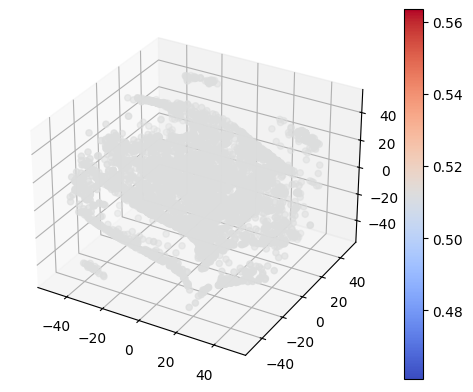

In [135]:
## Test the network and plot the results
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

features_list = []
labels_list = []
probability_list = []
predictions_list = []
acc = Accuracy(task = 'binary')

dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

with torch.no_grad():
    for features, labels in dataloader_test:
        features = features.to(device)
        labels = labels.to(device)
        labels = ((labels + 1) / 2).float()
        probability = net(features)
        outputs = (probability >= 0.5).float()
        outputs = outputs.squeeze()

        acc.update(outputs, labels)

        # Move features, labels, and outputs to CPU and convert them to numpy arrays
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        probability_list.append(probability.cpu().numpy())
        predictions_list.append(outputs.cpu().numpy())
accuracy = acc.compute()
print(f'Accuracy: {accuracy}')

# Concatenate all batches
features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)
probability = np.concatenate(probability_list, axis=0)
predictions = np.concatenate(predictions_list, axis=0)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features colored by the predictions
scatter = ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=probability, cmap='coolwarm')

# Add a color bar
plt.colorbar(scatter)

plt.show()

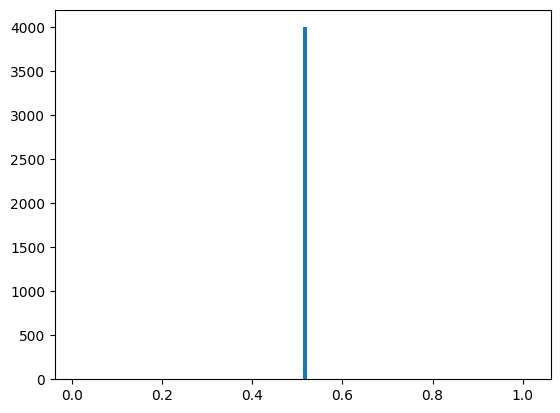

In [136]:
import matplotlib.pyplot as plt
plt.hist(probability, bins=100)
plt.show()

The model leads to random guess(one guess for all points) when only trained by near-boundary points. We augment the dataset by adding points further away from the boundary. We adapt two approaches:
1. Combine the set of near-boundary points to the set of uniformly chosen points. (100000+20000=120000)
2. For each near-boundary points, we run the trajectory to collect five more points along the way. (6*20000=120000)

## Dataset improvement

In [137]:
## Combine two csv files
df1 = pd.read_csv('dataset_near.csv')
df2 = pd.read_csv('dataset_large.csv')

combined_df = pd.concat([df1, df2])
combined_df.to_csv('combined_dataset_merge.csv', index=False)

In [ ]:
## For each near-boundary point, integrate the Lorenz system to compute the trajectory. We collect five more points along the trajectory as
## follows: compute the distance between the near-boundary point and the attractor as d. We require the previous point to be at least 0.2d away
## from the next. We compute the trajectory until t=1500.

def point_collection(near_boundary_point, d, num_points=5):
    tmax, n = 1500, 100000
    soln = solve_ivp(lorenz, (0, tmax), near_boundary_point, args=(sigma, beta, r), dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y, z = soln.sol(t)
    collected_points = []
    collected_points.append(near_boundary_point)
    for i in range(1, n):
        if euclidean_distance(collected_points[-1], np.array([x[i], y[i], z[i]])) > 0.2 * d:
            collected_points.append(np.array([x[i], y[i], z[i]]))
        if len(collected_points) == num_points+1:
            break
    return collected_points



In [ ]:
from tqdm import tqdm

expanded_dataset = []
expanded_labels = []

for _, row in tqdm(df1.iterrows(), total=df1.shape[0]):
    near_boundary_point = np.array([row.x0, row.y0, row.z0])
    label = row.attracted
    d = euclidean_distance(near_boundary_point, lorenz_attractor)
    points = point_collection(near_boundary_point, d)
    expanded_dataset.extend(points)
    expanded_labels.extend([row.attracted] * len(points))

expanded_dataset_df = pd.DataFrame(expanded_dataset, columns=['x0', 'y0', 'z0'])
expanded_labels_df = pd.DataFrame(expanded_labels, columns=['attracted'])
expanded_df = pd.concat([expanded_dataset_df, expanded_labels_df], axis=1)

expanded_df.to_csv('combined_dataset_expand.csv', index=False)

In [140]:
## Verify the generated dataset
expanded_df = pd.read_csv('combined_dataset_expand.csv')
expanded_df_1 = expanded_df[expanded_df['attracted'] == 1]
expanded_df_n1 = expanded_df[expanded_df['attracted'] == -1]

for i, row in expanded_df_1.iterrows():
    if not simulation(row['x0'], row['y0'], row['z0']):
        print(f"Error: {row['x0']}, {row['y0']}, {row['z0']}")
print("Done with label 1")

for i, row in expanded_df_n1.iterrows():
    if simulation(row['x0'], row['y0'], row['z0']):
        print(f"Error: {row['x0']}, {row['y0']}, {row['z0']}")
print("Done with label -1")

Error: 2.0851467572191673, 27.707404702801902, -2.8451599234478273
Error: -14.850242663254033, -1.240073883458715, 32.95603005633152
Error: -10.133097672167082, 6.760404094268452, 29.346040596062306
Error: 3.384749323170455, 31.200481266944372, 14.140201781133156
Error: 14.433554715123432, 22.952343699247823, 27.286957631602025
Error: 15.361850687522235, 13.116972987024278, 33.126586936554986
Error: 19.424367841857578, 47.65448181360623, 6.118774348762507
Error: -14.371788556701784, 24.483669065045643, -28.400604791058235
Error: 0.6304428514834177, 5.476924925857647, -26.7609693878564
Error: 5.508506703226866, 12.98003273407502, -18.810963119922732
Error: 9.6488897496304, 20.632914424388613, -11.255157227132235
Error: -7.287546894160718, 8.031074910369224, -29.912267829726954


KeyboardInterrupt: 